# Data Ted
## Analisi dei Ted Talk
---
#### Matano Francesco S5253162
#### Vassallo Edoardo S4965918 
---

# Indice
---
0. Preparativi
    1. Librerie Imporate
    2. Funzioni utilizzate per il notebook
    3. Definizione di array globali utilizzati all'interno del notebook
    4. Import Dataset
1. Pulizia Dati
2. Visualizzazione dei Dati
3. Test Statistici
    1. T-TEST
    2. TEST CHI-QUADRO
4. Modello predittivo
    1. TEST REGRESSION VIEWS, LIKES -> DATA
5. Clustering
--- 

# Introduzione ed Obiettivi
Il nostro obbiettivo è analizzare l'evoluzione nel tempo dei dati in nostro possesso, relativi ai video pubblicati sulla piattaforma Ted-Ed. <br> Secondariamente, intendiamo studiare le eventuali differenze fra sottogruppi della popolazione, ottenuti tramite operazioni di quantizzazione e tagging

# 0. Preparativi
> ## Librerie importate


In [1]:
##LIB FOR UTIL THING
import os
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.metrics as metrics 
import re
import math
##LIB FOR ML THING
import pandas as pd 
import scipy.stats as stats
import datetime as dt
import sklearn
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB

> ## Funzioni utilizzate per il notebook

In [2]:
def print_stats_field(df, field):
    print("--------------------------------------------"   )
    print("Statistiche relative a:  ", field               )
    print("--------------------------------------------"   )
    print("Media:                   ",  df[field].mean()   )
    print("Moda:                    ",  df[field].mode()[0])
    print("Mediana:                 ",  df[field].median() )
    print("Varianza:                ",  df[field].var()    )
    print("Deviazione standard:     ",  df[field].std()    ) 
    print("--------------------------------------------"   )

In [3]:
def print_all_olap_on_first_dim(olap_df, xlabel, ylabel, list_of_labels):

    cols = (len(list_of_labels) // 5) + 1

    plt.figure(figsize=(20, 30))

    for element in range(0, len(list_of_labels)):
        plt.subplot(cols, 5, element+1)
        plt.title(list_of_labels[element])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.imshow(olap_df[element, :, :])
        plt.colorbar()

        for (j,i),label in np.ndenumerate(olap_df[element, :, :]):
            plt.text(i,j,"{:.0f}".format(label),ha='center',va='center')

    plt.show()

In [4]:
def print_ttest_1samp(first_dataset, second_dataset, column, name):
    t, p_value = stats.ttest_1samp(a = first_dataset[column].values, popmean= second_dataset[column].mean())
    print("\nt-test on ", name, ":")
    print('Valore test: ', t)
    print('P-value: ', p_value)

In [5]:
def print_chi_squared(obs, exp, name):
    chi_squared, p_value = stats.chisquare(f_obs= obs, f_exp = exp)
    print("\nt-test on ", name, ":")
    print('Chi-quadrato: ', chi_squared)
    print('P-value: ', p_value)

In [6]:
def cluster_df(df, x_label, y_label, z_label, n_cluster, make_plot = 0):
    scaler = preprocessing.MinMaxScaler()
    tmp = df[[x_label, y_label, z_label]]
    scaler.fit(tmp)
    scaled = scaler.fit_transform(tmp)
    scaled_df = pd.DataFrame(scaled, columns=tmp.columns)
    kmeans = KMeans(n_clusters= n_cluster, random_state=0, n_init='auto')
    kmeans.fit(scaled_df)
    
    if make_plot != 0:
        fig = plt.figure()

        ax = plt.axes(projection ='3d')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_zlabel(z_label)
        ax.scatter(scaled_df[x_label].values, scaled_df[y_label].values, scaled_df[z_label].values, c = kmeans.labels_, alpha=0.5)
    # create_3d_plot_gif(ax, fig)
    return silhouette_score(scaled_df, kmeans.labels_), kmeans.cluster_centers_


In [7]:
def create_3d_plot(xy_struct, z_struct, x_label, y_label, lin_reg, plt):
    ###Create x, y surface meshgrid
    x_surf, y_surf = np.meshgrid(
                                  np.linspace(xy_struct[x_label].min(), xy_struct[x_label].max(), 100),
                                  np.linspace(xy_struct[y_label].min(), xy_struct[y_label].max(), 100)
                                )

    onlyX = pd.DataFrame({x_label : x_surf.ravel(), y_label: y_surf.ravel()})
    fittedY = np.array(lin_reg.predict(onlyX))
    z_pred = lin_reg.predict(xy_struct)

    print('Score:', lin_reg.score(xy_valid, z_valid))
    
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.plot_surface(x_surf, y_surf, fittedY.reshape(x_surf.shape), color='green', alpha=0.3)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_struct, color='red', alpha=0.7)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_pred)
    ax.set_title('Piano di predizione e dati di training')
    # create_3d_plot_gif(ax, fig)
    plt.show()
    return z_pred


In [8]:
def create_3d_plot_gif(ax, fig):
    # DA INSTALLARE PER LA GENERAZIONE DELLE GIF
    import imageio.v2 as imageio # pip install imageio
    from natsort import natsorted # pip install natsort

    png_dir = 'gif_production/resources'
    images = []

    # generiamo i frame
    for ii in np.arange(0, 360, 1):
          ax.view_init(elev=32, azim=ii)
          fig.savefig('gif_production/resources/frame_%d.png' % ii)

    # generiamo la gif
    for file_name in natsorted(os.listdir(png_dir)):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

    # Make it pause at the end so that the viewers can ponder
    for _ in range(10):
        images.append(imageio.imread(file_path))

    imageio.mimsave('gif_production/gif/movie.gif', images, fps=120)


In [9]:
def MAE(valid, pred_valid):
    if len(valid) != len(pred_valid):
        print("Il numero di dati validi deve essere uguale a quelli predetto")
        return -1
    return_val = 0
    for x in range(len(valid)):
        return_val += abs(valid[x] - pred_valid[x])
    return (return_val/len(valid))

In [10]:
def MSE(valid, pred_valid):
    if len(valid) != len(pred_valid):
        print("Il numero di dati validi deve essere uguale a quelli predetto")
        return -1
    return_val = 0
    for x in range(len(valid)):
        return_val += math.pow((valid[x] - pred_valid[x]), 2)
    return (return_val/len(valid))

In [11]:
def RMSE(valid, pred_valid):
    mse_ret = MSE(valid, pred_valid)
    return math.sqrt(mse_ret)

In [12]:
def corr_matrix_fun(df, label_list, title):
    corr_matrix = df[label_list].corr()
    plt.title(title)
    plt.imshow(corr_matrix)
    plt.xticks([x for x in range(len(label_list))], label_list )
    plt.yticks([x for x in range(len(label_list))], label_list )
    plt.colorbar()
    for (j,i),label in np.ndenumerate(corr_matrix):
        plt.text(i,j,"{:.4f}".format(label),ha='center',va='center')

In [13]:
def cov_matrix_fun(df, labels, title):
    cov_matrix = daTed[labels].cov()
    plt.title(title)
    plt.imshow(cov_matrix)
    plt.xticks([x for x in range(len(labels))], labels )
    plt.yticks([x for x in range(len(labels))], labels )
    plt.colorbar()
    for (j,i),label in np.ndenumerate(cov_matrix):
        plt.text(i,j,"{:.2f}".format(label),ha='center',va='center')

> ##  Definizione di array globali utilizzati all'interno del notebook
 (N.B.) Nella quantizzazione relativa agli anni, si è deciso di catalogare tutti gli anni precedenti al 2000 in un unico gruppo, sulla base dei componenti della popolazione.<br>
 Si è anche deciso di quantizzare l'insieme dei dati per tag (non essendoci il campo tag vero e proprio ci siamo ricavati il tag cercando la parola nel titolo del TEDTALK) abbiamo preso in considerazione i tag più in voga sul sito dei TEDTALK: climate, COVID, health, war, AI, like, love, brain, life, science, culture, data ,music e like.

In [14]:
#quantizzazione dell views
quantize_views = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '1M-20M', '>20M'  ]
#quantizzazione dei likes
quantize_likes = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '>1M'             ]
#lista dei tag
tag            = ["climate","COVID","health","war","AI","like","love",
                  "brain","life","science","culture","data","music" ] 

---

> ## Import Dataset

In [15]:
daTed = pd.read_csv("data_ted.csv")
daTed.info()
daTed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5440 non-null   object
 1   author  5439 non-null   object
 2   date    5440 non-null   object
 3   views   5440 non-null   int64 
 4   likes   5440 non-null   int64 
 5   link    5440 non-null   object
dtypes: int64(2), object(4)
memory usage: 255.1+ KB


,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


Creazione della colonne tag e id_tag nel dataframe in cui: nel primo c'è il nome del tag a cui il ted talk fa parte mentre nella seconda c'è l'id del tag nella lista globale tag. 

In [16]:
daTed["tag"] = "nontrovato"
daTed["id_tag"] = -1
for x in range(len(tag)):
    daTed.loc[daTed["title"].str.contains(tag[x]), "tag"] = tag[x]
    daTed.loc[daTed["title"].str.contains(tag[x]), "id_tag"] = x
print("Numero dei ted talk trovati relativi ai tag")
daTed["tag"].value_counts()

Numero dei ted talk trovati relativi ai tag


tag
nontrovato    4606
life           179
brain           85
climate         82
health          70
war             68
science         62
like            62
data            53
love            53
music           48
AI              35
COVID           19
culture         18
Name: count, dtype: int64

# 1. Pulizia Dati

Analizzando i nostri dati, abbiamo ritrovato i seguenti errori:

1. È presente una riga con autore mancante

In [17]:
print(daTed.loc[(daTed['author'].isnull())])

                   title author           date  views  likes  \
3039  Year In Ideas 2015    NaN  December 2015    532     15   

                                          link         tag  id_tag  
3039  https://ted.com/talks/year_in_ideas_2015  nontrovato      -1  


2. Due delle righe presenti vengono erroneamente datati al gennaio 1970, data sospetta in quanto valore minimo dei timestamp UNIX.<br> L'errore è stato verificato cercando i video in questione online.

In [18]:
print(daTed.loc[(daTed['date'] == 'January 1970')])

                                 title          author          date   views  \
736               Innovations in sleep      Beautyrest  January 1970   60000   
738  Love letters to what we hold dear  Debbie Millman  January 1970  192000   

     likes                                               link         tag  \
736   1800  https://ted.com/talks/beautyrest_innovations_i...  nontrovato   
738   5700  https://ted.com/talks/debbie_millman_love_lett...  nontrovato   

     id_tag  
736      -1  
738      -1  


Siccome questi errori riguardano solo un paio di righe, si è deciso di correggere le righe, invece che eliminarle, nel seguente modo:

1. Vedendo [il video in questione](https://www.ted.com/talks/year_in_ideas_2015) si è visto che si tratta di un video celebrativo realizzato dall'azienda stessa. Si è deciso quindi di attribuirlo all'autore *"TED"*.

In [19]:
daTed.loc[(daTed['author'].isnull()), 'author'] = 'TED'
print(daTed.loc[(daTed['author'].isnull())])

Empty DataFrame
Columns: [title, author, date, views, likes, link, tag, id_tag]
Index: []


2. Similmente, possiamo rintracciare la data di pubblicazione dei video online *"Innovations in sleep"* è stato [caricato](https://youtu.be/mo264ECPacQ?si=O2mQA_2kww7flGm3) sulla pagina Youtube di TED nel Luglio 2020.<br>  *"Love letters to what we hold dear"* è stato presentato nel corso di TED2020.<br> Cercando la [scaletta](https://tedlive.ted.com/webcasts/t2020/session/419) dell'evento, scopriamo che è stato presentato nel Giugno di quell'anno.

In [20]:
daTed.loc[(daTed['title'] == 'Innovations in sleep'),              'date'] = 'July 2020'
daTed.loc[(daTed['title'] == 'Love letters to what we hold dear'), 'date'] = 'June 2020'

print(daTed.loc[(daTed['date'] == 'January 1970')])

Empty DataFrame
Columns: [title, author, date, views, likes, link, tag, id_tag]
Index: []


L'ultima correzione necessaria è al **formato delle date**. <br>
Al momento la data di pubblicazione è memorizzata come una stringa mese-anno. <br>Decidiamo di tradurla nel tipo *datetime*, per aiutare in seguito.

In [21]:
daTed["date"] = pd.to_datetime(daTed['date'], format='%B %Y')

# 2. Visualizzazione dei dati

La nostra analisi si basa principalmente sullo studio dell'evoluzione temporale dei dati e anche sull'analisi dei video basandoci su dei tag.<br> Cominciamo quindi mostrando un grafico del numero di uscite rispetto all'anno.

<AxesSubplot: title={'center': 'Numero di Video per Anno'}, xlabel='Anno', ylabel='N° Video'>

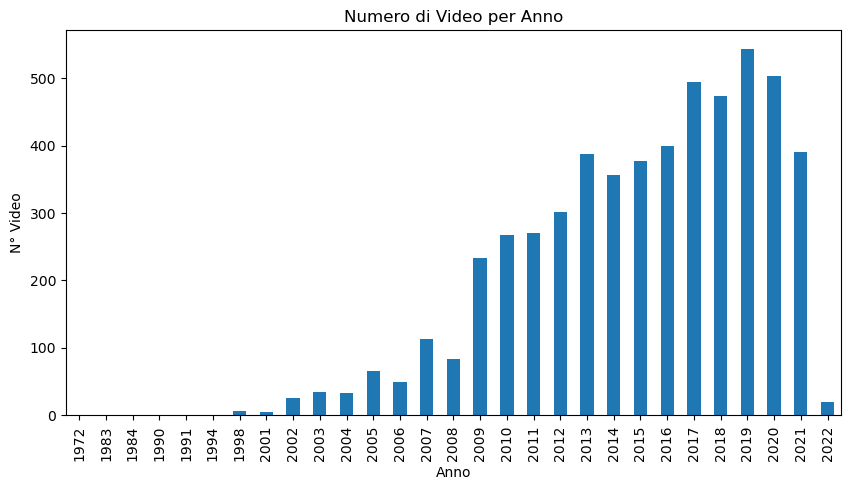

In [22]:
daTed.groupby(daTed.date.dt.year)['title'].count().plot( kind    = 'bar', 
                                                         figsize = (10,5), 
                                                         ylabel  = "N° Video", 
                                                         xlabel  = "Anno", 
                                                         title   = "Numero di Video per Anno" )

Da questo grafico possiamo notare la crescita negli anni del numero di video, in particolare in seguito al 2009. Inoltre, la maggior parte dei video è uscita nel decennio 2010-2019 (si può anche vedere come l'anno 2019 sia stato l'anno con il maggior numero di video usciti)

Di seguito anche la visualizzazione del numero dei ted talk presenti per i vari tag utilizzati.<br>
Abbiamo creato un nuovo dataframe daTag togliendo tutti i video dei TEDTALK che non erano inclusi in nessun dei tag sopracitati.

<AxesSubplot: title={'center': 'Numero di Video per tag'}, xlabel='Tag', ylabel='N° Video'>

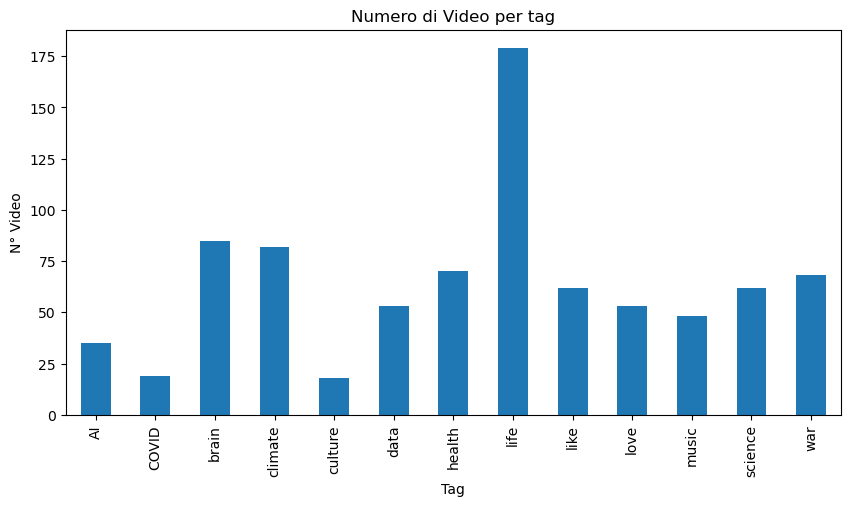

In [23]:
daTag = daTed[daTed["id_tag"] != -1]
daTag.groupby(daTag.tag)['tag'].count().plot( kind    = 'bar', 
                                                         figsize = (10,5), 
                                                         ylabel  = "N° Video", 
                                                         xlabel  = "Tag", 
                                                         title   = "Numero di Video per tag" )

Cerchiamo di vedere ora se c'è una correlazione tra il tag in cui è incluso il video e il numero di views che riceve quest'ultimo.<br>
Di seguito la stampa riguardo alla matrice di correlazione tra i tag dei video, le views e i like che ottiene.

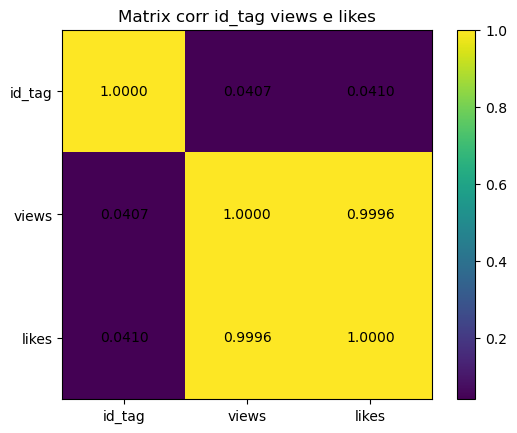

In [24]:
corr_matrix_fun(daTag, ["id_tag", "views", "likes"], "Matrix corr id_tag views e likes" )

Da questa matrice si può notare come la correlazione tra le varie variabili (id_tag, views e likes) non è molto forte.

Vediamo ora di studiare la **qualità** di questi video, sulla base dei valori di like e visualizzazioni. Realizziamo a tal scopo, un **OLAP** ad hoc, **quantizzando** le colonne dei likes, views, e data di pubblicazione.

In [25]:
# Quantizzazione per anno
## p.s. min year: 1972
##      max year: 2022

daTed["date_year"] = daTed["date"].dt.year
quantize_years = sorted(daTed["date_year"].unique())

# Quantizzazione per quantità di views
## p.s. max views: 72M

daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
daTed.loc[daTed['views'].between(10000    , 99999   , 'both'), 'views_quant'] = quantize_views[1]
daTed.loc[daTed['views'].between(100000   , 499999  , 'both'), 'views_quant'] = quantize_views[2]
daTed.loc[daTed['views'].between(500000   , 999999  , 'both'), 'views_quant'] = quantize_views[3]
daTed.loc[daTed['views'].between(1000000  , 19999999, 'both'), 'views_quant'] = quantize_views[4]
daTed.loc[daTed['views'].between(20000000 , 80000000, 'both'), 'views_quant'] = quantize_views[5]

# Quantizzazione per quantità di likes
## p.s. max likes: 2.1M

daTed.loc[daTed['likes'].between(0       , 9999    , 'both'), 'likes_quant'] = quantize_likes[0]
daTed.loc[daTed['likes'].between(10000   , 99999   , 'both'), 'likes_quant'] = quantize_likes[1]
daTed.loc[daTed['likes'].between(100000  , 499999  , 'both'), 'likes_quant'] = quantize_likes[2]
daTed.loc[daTed['likes'].between(500000  , 999999  , 'both'), 'likes_quant'] = quantize_likes[3]
daTed.loc[daTed['likes'].between(1000000 , 10000000, 'both'), 'likes_quant'] = quantize_likes[4]

daTed.info()
daTed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        5440 non-null   object        
 1   author       5440 non-null   object        
 2   date         5440 non-null   datetime64[ns]
 3   views        5440 non-null   int64         
 4   likes        5440 non-null   int64         
 5   link         5440 non-null   object        
 6   tag          5440 non-null   object        
 7   id_tag       5440 non-null   int64         
 8   date_year    5440 non-null   int32         
 9   views_quant  5440 non-null   object        
 10  likes_quant  5440 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(6)
memory usage: 446.4+ KB


,title,author,date,views,likes,link,tag,id_tag,date_year,views_quant,likes_quant
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,2021-12-01,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...,nontrovato,-1,2021,100K-500K,10K-100K
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,2022-02-01,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...,nontrovato,-1,2022,100K-500K,<10K
2,How play can spark new ideas for your business,Martin Reeves,2021-09-01,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...,nontrovato,-1,2021,100K-500K,10K-100K
3,Why is China appointing judges to combat clima...,James K. Thornton,2021-10-01,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...,climate,0,2021,100K-500K,10K-100K
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,2021-10-01,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...,nontrovato,-1,2021,<10K,<10K


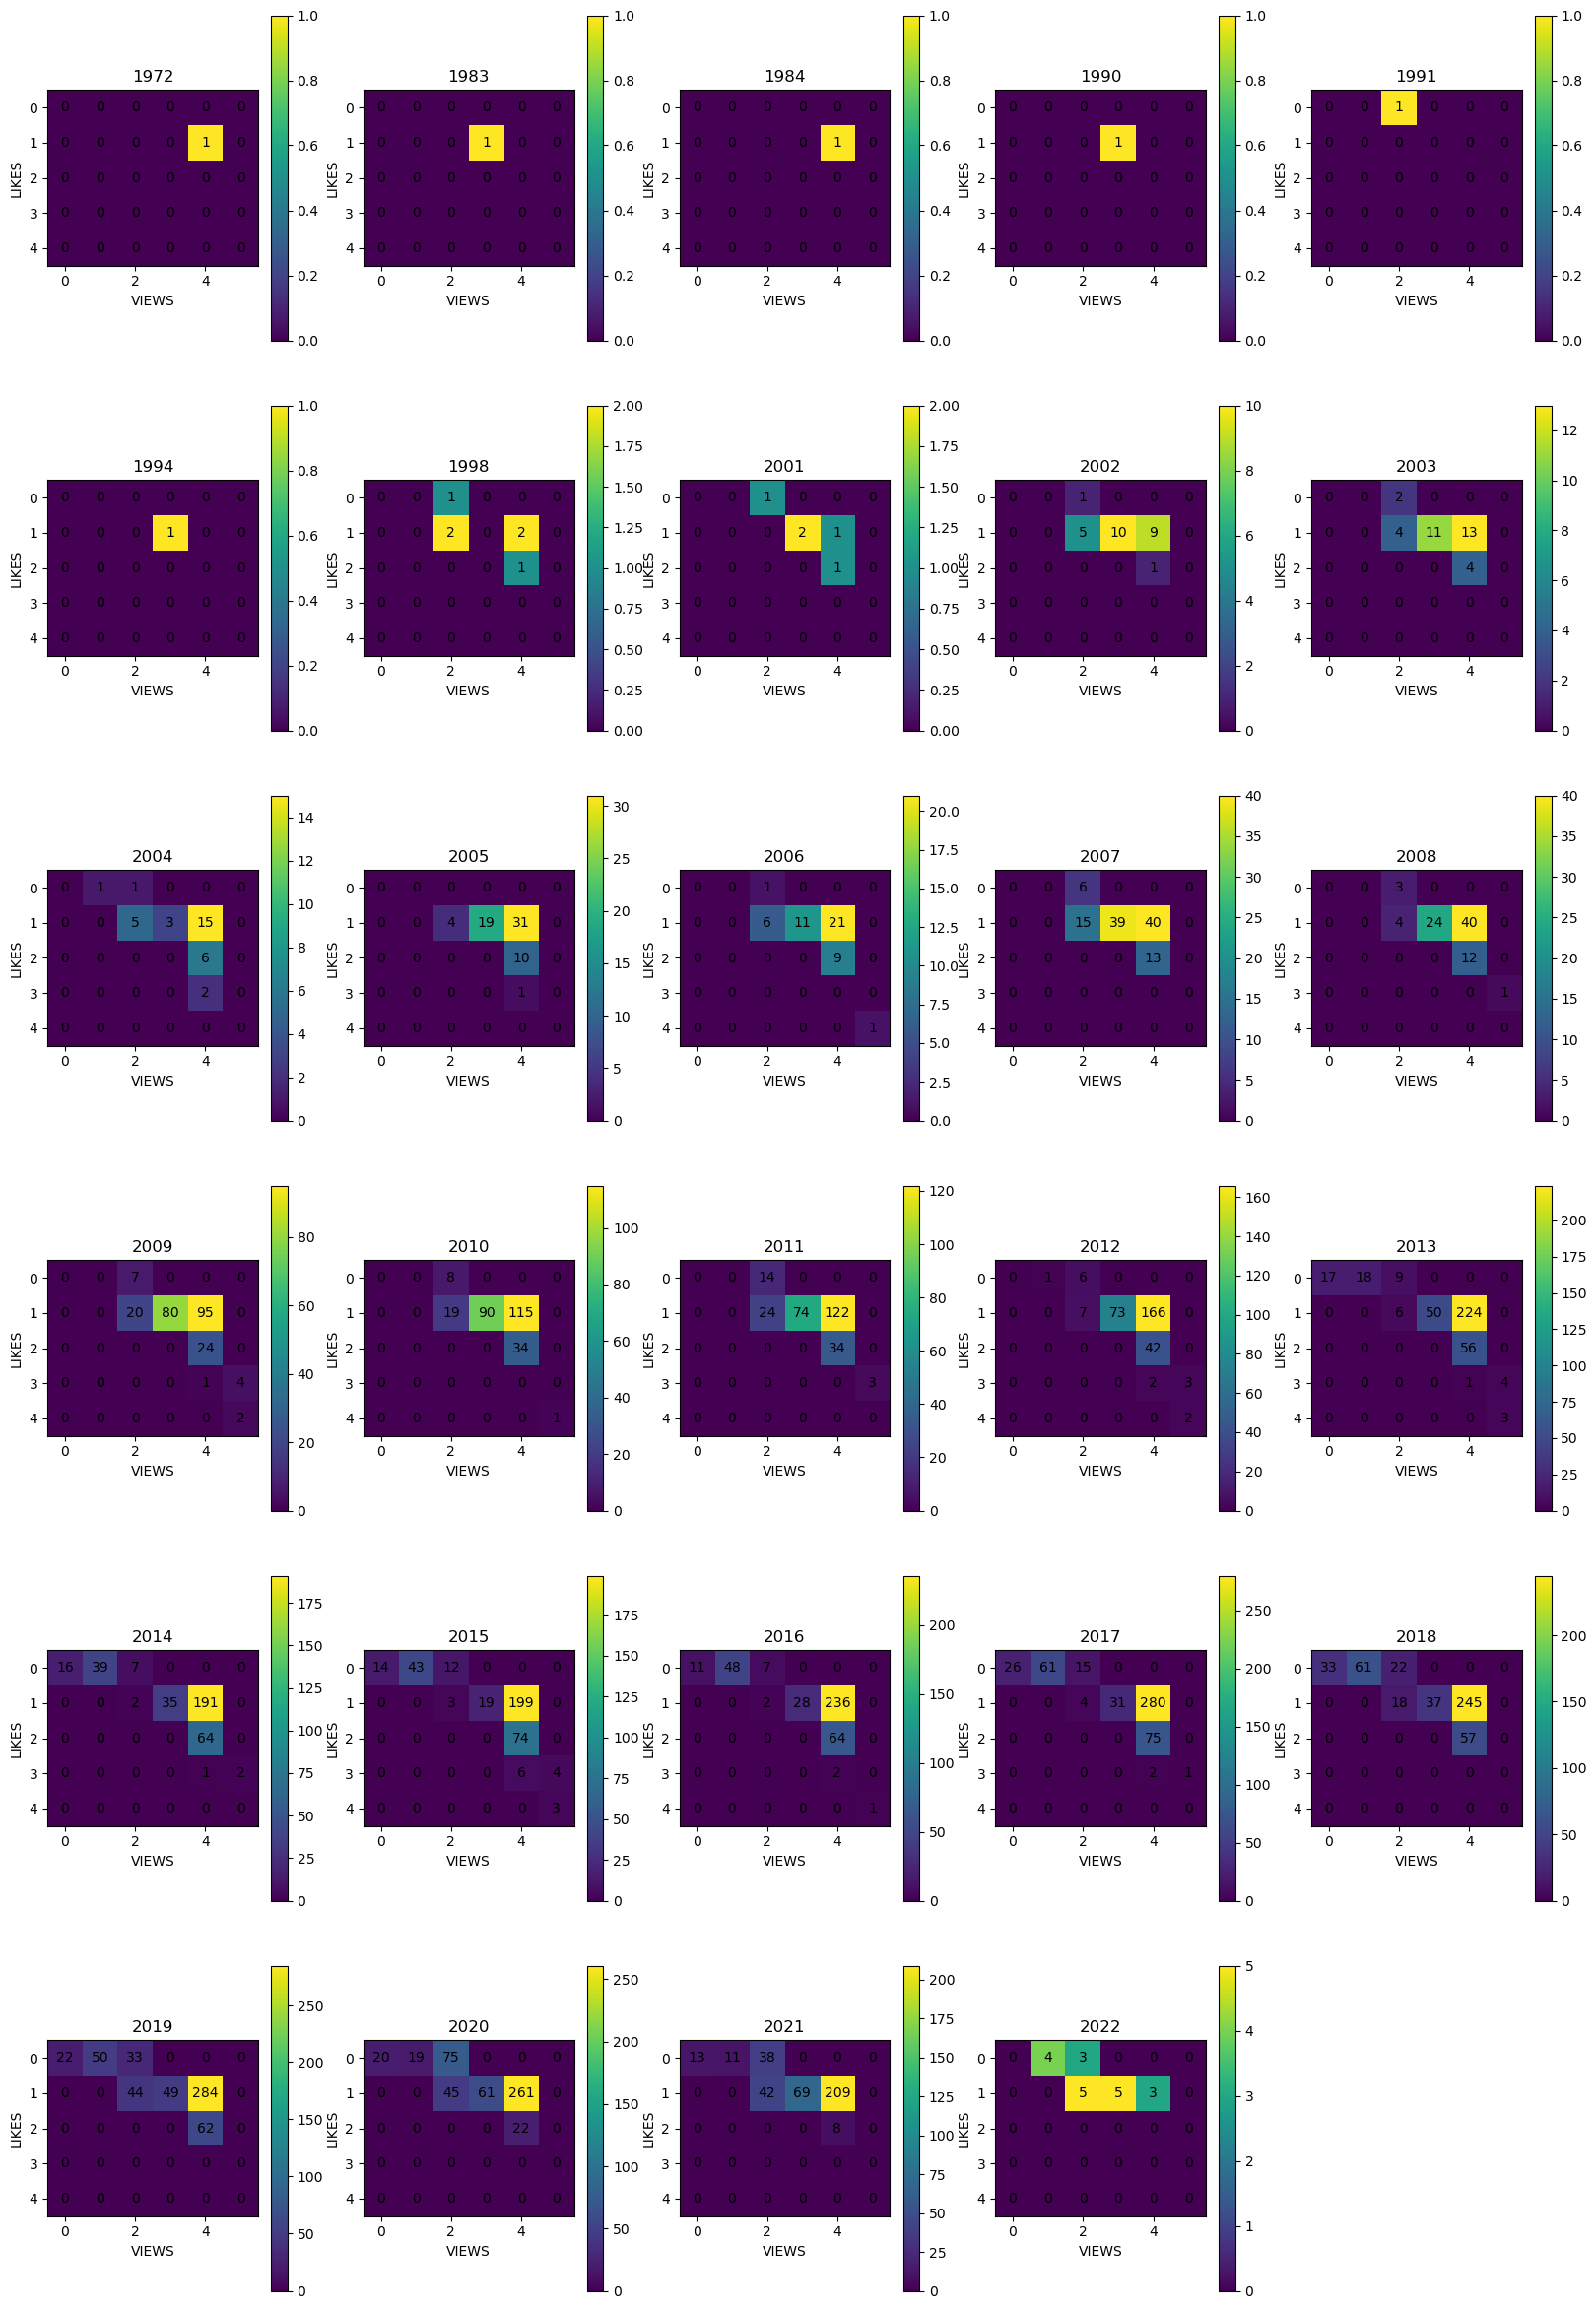

In [26]:
##OLAP che ha come dimensioni: x: le date quantizzate, y: le views quantizzate e z: il numero di like quantizzati
OLAP  = np.zeros((len(quantize_years), len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    views_class = daTed[daTed['views_quant'] == quantize_views[z]]
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_years)):
            OLAP[x,y,z] = np.sum(
                                (views_class['likes_quant'] == quantize_likes[y]) & 
                                (views_class['date_year']  == quantize_years[x] ) )

print_all_olap_on_first_dim(OLAP, "VIEWS", "LIKES", quantize_years)

Dalla visualizzazione OLAP notiamo che, nonostante la quantità dei video vari notevolmente fra anno ed anno, il rapporto fra views e likes rimane quasi sempre costante (la maggior parte dei video sembra possedere 1M-20M visualizzazioni e 10K-100K like). <br>
Questo può quindi implicare un rapporto fra le due
<br>
<br>
I dati stampati di seguito corrispondono con la visualizzazione 

In [27]:
print_stats_field(daTed, "date_year")
print_stats_field(daTed, 'views')
print_stats_field(daTed, 'likes') 

--------------------------------------------
Statistiche relative a:   date_year
--------------------------------------------
Media:                    2015.0152573529413
Moda:                     2019
Mediana:                  2016.0
Varianza:                 20.2702212979795
Deviazione standard:      4.502246250259919
--------------------------------------------
--------------------------------------------
Statistiche relative a:   views
--------------------------------------------
Media:                    2061575.9579044117
Moda:                     1300000
Mediana:                  1300000.0
Varianza:                 12724186465893.203
Deviazione standard:      3567097.7651156695
--------------------------------------------
--------------------------------------------
Statistiche relative a:   likes
--------------------------------------------
Media:                    62607.616727941175
Moda:                     39000
Mediana:                  40500.0
Varianza:                 11

Per studiare la correlazione intuita, stampiamo il grafico relativo al rapporto fra views e likes

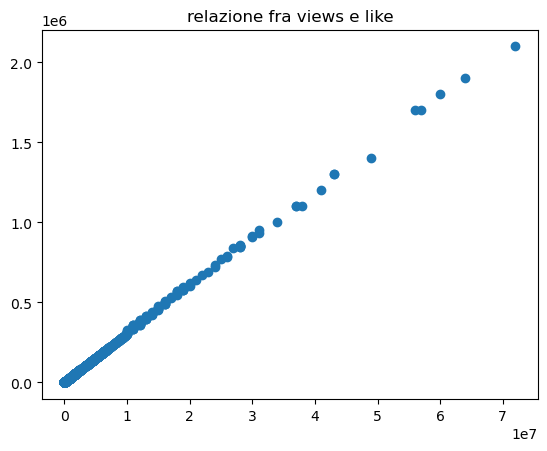

In [28]:
plt.title("relazione fra views e like")
plt.scatter(daTed["views"], daTed["likes"])

Il grafico ci mostra ancora più evidenza di questo rapporto. <br>
Calcolando covarianza e correlazione, la loro relazione appare ancora più ovvia

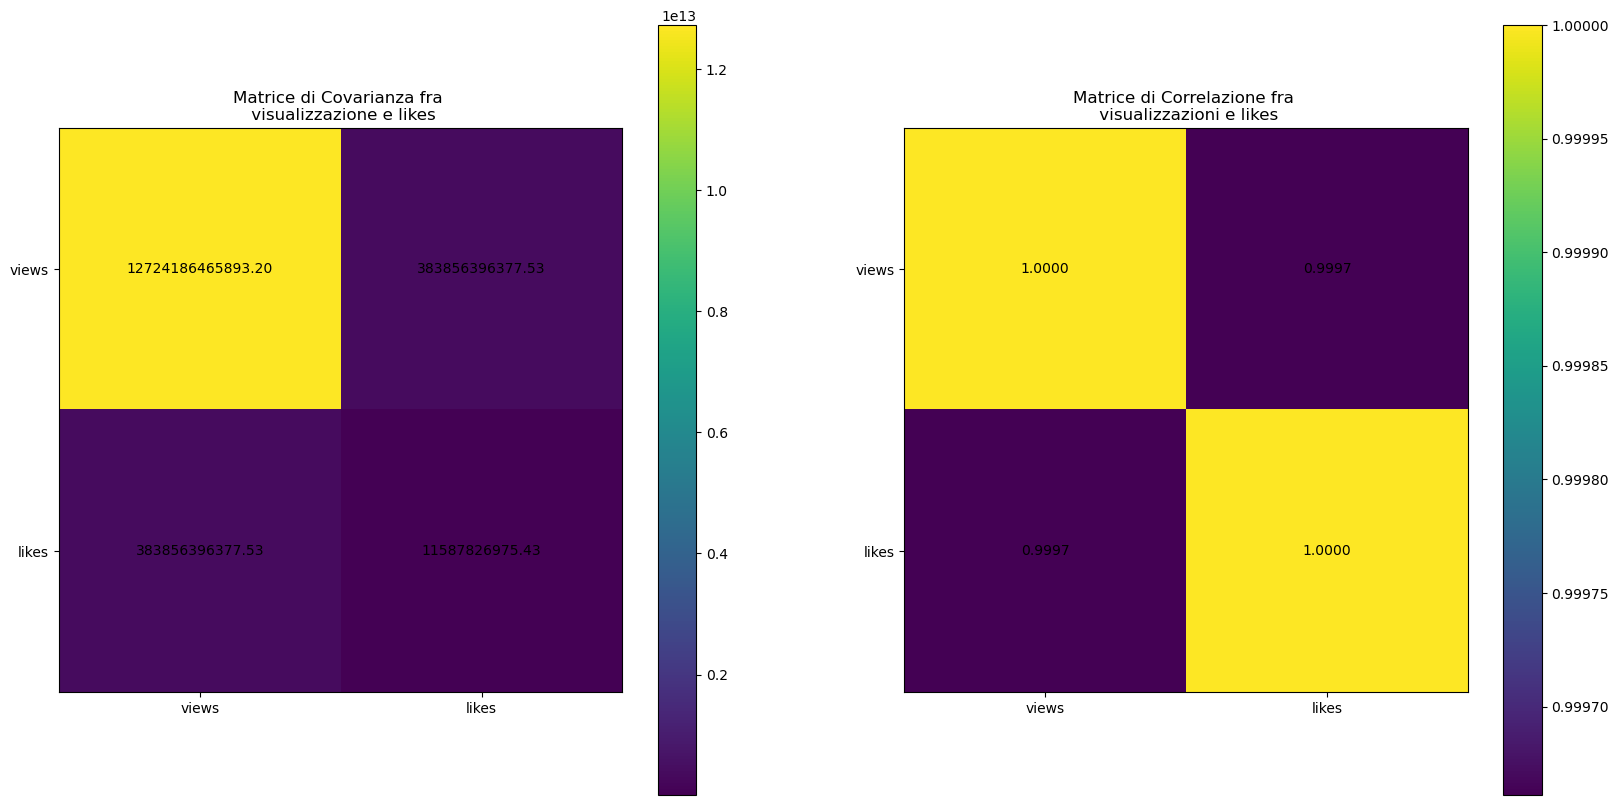

In [29]:
plt.figure(figsize=(20, 10)) 
plt.subplot(1, 2, 1)
cov_matrix_fun(daTed, ["views", "likes"], "Matrice di Covarianza fra \n visualizzazione e likes")
plt.subplot(1, 2, 2)
corr_matrix_fun(daTed, ["views", "likes"], "Matrice di Correlazione fra \n visualizzazioni e likes")

# 3. Test Statistici

## T-TEST sui dati temporali

#####  Ipotesi: ipotizziamo che la media delle views ottenute nei vari bienni sia simile alla media totale delle view dei dati presenti nel dataset (e che quindi non possa esistere un ipotesi alternativa). </u>

<AxesSubplot: title={'center': 'views'}, xlabel='date_year'>

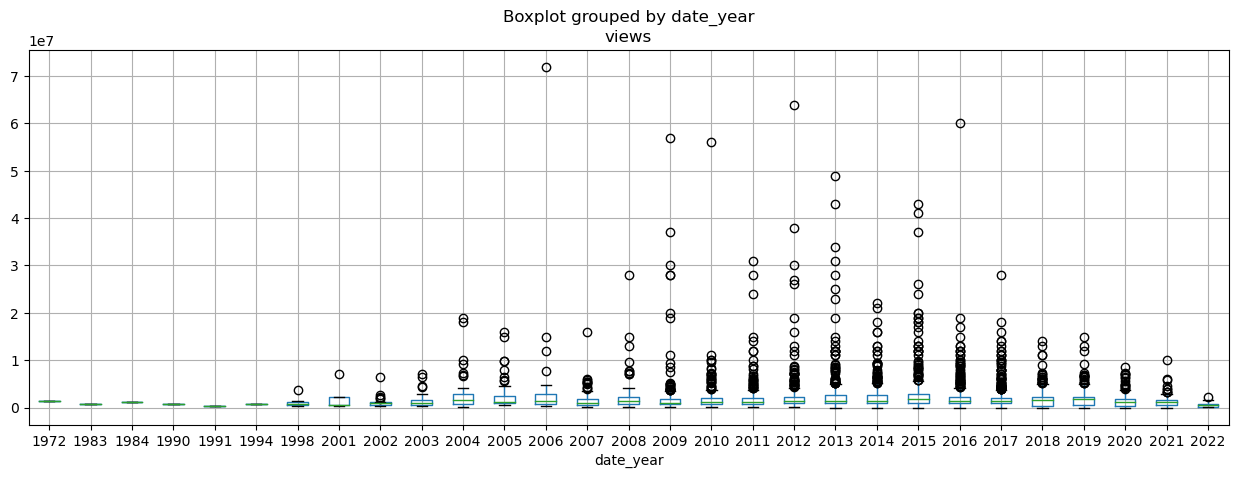

In [30]:
daTed.boxplot(column = "views", by = "date_year", figsize=(15, 5))

Come si può notare dai boxplot qui sopra sono presenti molti outliers nelle decadi: 00's, 10's e 20's.
Considerando che queste sono le decadi con il maggior numero di dati ci aspettiamo anche una varianza complessiva motlo  alta.

In [31]:
popolazione = len(daTed)

for x in range(len(quantize_years)):
    campione =  len(daTed.loc[daTed["date_year"] == quantize_years[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
            print_ttest_1samp(daTed.loc[daTed["date_year"] == quantize_years[x]], daTed, "views", quantize_years[x])



t-test on  2003 :
Valore test:  -1.6220743309082197
P-value:  0.11430419047759649

t-test on  2004 :
Valore test:  1.6483243246368204
P-value:  0.10907151218856788

t-test on  2005 :
Valore test:  0.9244821610187695
P-value:  0.3587080119761623

t-test on  2006 :
Valore test:  1.1058932244066195
P-value:  0.27428484729210995

t-test on  2007 :
Valore test:  -2.765894607095807
P-value:  0.00664154617990903

t-test on  2008 :
Valore test:  0.9855743843117651
P-value:  0.32720638363810606

t-test on  2009 :
Valore test:  0.8896853708003017
P-value:  0.37455645574427776

t-test on  2010 :
Valore test:  -0.35970547331330066
P-value:  0.7193528058847316

t-test on  2011 :
Valore test:  0.29977056959568793
P-value:  0.7645828122513227

t-test on  2012 :
Valore test:  1.9468762427830237
P-value:  0.052479531668387265

t-test on  2013 :
Valore test:  2.6748226813474663
P-value:  0.0077940104199484056

t-test on  2014 :
Valore test:  1.568125068405824
P-value:  0.11774033494700097

t-test on  2

Come si può notare dai risultati ottenuti dai ttest svolti, si può vedere come, a meno del caso dei TED degli anni: 2007,2013, 2015 non possiamo rifiutare il caso della ipotesi nulla (in quanto negli altri casi in cui è possibile fare il ttest ci vengono fuori dei p-value che sono maggiori del nostro livello di significatività che è di 0.05).<br>

In [33]:
print("Media di tutto il dataset", daTed['views'].mean())

for x in range(len(quantize_years)):
    campione =  len(daTed.loc[daTed["date_year"] == quantize_years[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
        print("Media anno", quantize_years[x], ": ", daTed.loc[daTed["date_year"] == quantize_years[x]]['views'].mean())


Media di tutto il dataset 2061575.9579044117
Media anno 2003 :  1599823.5294117648
Media anno 2004 :  3405393.9393939395
Media anno 2005 :  2422738.446153846
Media anno 2006 :  3696122.4285714286
Media anno 2007 :  1563283.185840708
Media anno 2008 :  2476285.7023809524
Media anno 2009 :  2393283.261802575
Media anno 2010 :  1978074.9026217228
Media anno 2011 :  2124273.05904059
Media anno 2012 :  2659556.2913907287
Media anno 2013 :  2738498.7036082475
Media anno 2014 :  2309950.411764706
Media anno 2015 :  3062971.167108753
Media anno 2016 :  2328057.3834586465
Media anno 2017 :  2017962.8282828282
Media anno 2018 :  1716400.8393234673
Media anno 2020 :  1264803.578528827
Media anno 2021 :  1101868.4615384615


####  Risultato: non possiamo dire che esiste una ipotesi alternativa a quella nulla.
Si può vedere dalla stampa della varie medie dei dati qui seguente

## T-TEST sui TAG

#####  Ipotesi:  ipotizziamo che la media totale sulle varie views fatte dai vari ted talk sia simile a quella ottenuta nei vari raggrupamenti dei ted talk all'interno dei vari tag. </u>

In [50]:
popolazione = len(daTed)

for x in range(len(tag)):
    campione =  len(daTed.loc[daTed["tag"] == tag[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
            print_ttest_1samp(daTed.loc[daTed["tag"] == tag[x]], daTed, "views", tag[x])



t-test on  climate :
Valore test:  -5.177082817730289
P-value:  1.6076970864103636e-06

t-test on  health :
Valore test:  -6.042004170258757
P-value:  6.88273753224258e-08

t-test on  war :
Valore test:  -2.0887054622622268
P-value:  0.040536769876744747

t-test on  AI :
Valore test:  -1.0886342589441442
P-value:  0.2839718099834681

t-test on  like :
Valore test:  0.2310276445803188
P-value:  0.8180664739301396

t-test on  love :
Valore test:  1.9961747944229455
P-value:  0.05116368008401059

t-test on  brain :
Valore test:  2.7782233434701493
P-value:  0.006740922735554669

t-test on  life :
Valore test:  0.6451195928897905
P-value:  0.5196803193601651

t-test on  science :
Valore test:  -1.3987254094260997
P-value:  0.16695925373998735

t-test on  data :
Valore test:  -7.162602043056196
P-value:  2.7238759147582606e-09

t-test on  music :
Valore test:  -1.5183925485662615
P-value:  0.13561405622225464


## TEST CHI-QUADRO

#### ipotesi: ipotizziamo che dati i grafici visti prima, esista una corrispondenza tra numero di views e likes in un ted talks.

In [34]:
chi_square = np.zeros((len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_years)):
            chi_square[y,z] += OLAP[x, y, z]
res =  stats.chi2_contingency(chi_square)
print("Risultato della nostra contigency test: ", res.pvalue)

Risultato della nostra contigency test:  0.0


#### Il risultato ottenuto dal nostro test del chi-quadro conferma che esiste una corrispondenza tra numero di views e likes in un ted talks.

# 4. Modello predittivo

Proviamo a fare modello predittivo anno-count per vedere se si riesce ad ottenere un modello di rigressione lineare buono.

In [35]:
daTed['count_date'] = daTed.groupby(['date'])['title'].transform('count')
daTed['count_year'] = daTed.groupby(['date_year'])['title'].transform('count')

for x in quantize_years: 
    daTed.loc[daTed['date_year'] == x, 'mean_views_year'] = daTed.loc[daTed['date_year'] == x]["views"].mean()
daTed.head()

,title,author,date,views,likes,link,tag,id_tag,date_year,views_quant,likes_quant,count_date,count_year,mean_views_year
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,2021-12-01,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...,nontrovato,-1,2021,100K-500K,10K-100K,31,390,1.101868e+06
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,2022-02-01,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...,nontrovato,-1,2022,100K-500K,<10K,8,20,5.735000e+05
2,How play can spark new ideas for your business,Martin Reeves,2021-09-01,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...,nontrovato,-1,2021,100K-500K,10K-100K,27,390,1.101868e+06
3,Why is China appointing judges to combat clima...,James K. Thornton,2021-10-01,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...,climate,0,2021,100K-500K,10K-100K,72,390,1.101868e+06
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,2021-10-01,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...,nontrovato,-1,2021,<10K,<10K,72,390,1.101868e+06


Score: 0.7297070457520423


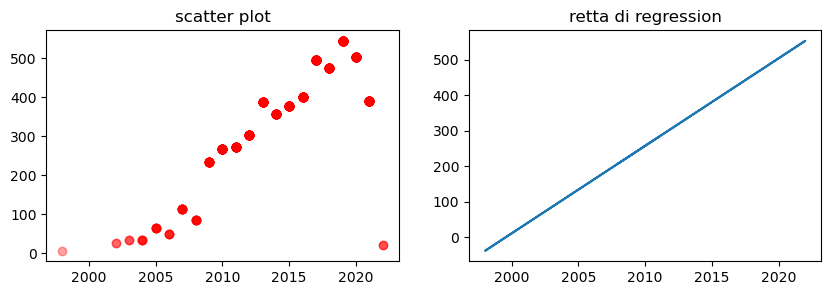

In [36]:
x = daTed[["date_year"]].values.astype(float)
y = daTed["count_year"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1)
regressor = LinearRegression()
lin_reg = regressor.fit(x_train, y_train) 

print('Score:', lin_reg.score(x_valid, y_valid))

y_hat = lin_reg.predict(x_valid)
plt.figure(figsize=(10, 3)) 

plt.subplot(1, 2, 1)
plt.title("scatter plot")
plt.scatter(x_valid,y_valid,c='r',alpha=0.2)

plt.subplot(1, 2, 2)
plt.title("retta di regression")
plt.plot(x_valid,y_hat)

plt.show()

Dallo score ottenuto dalla rigressione lineare fatta possiamo dire che il modello ottenuto è buono ma non perfetto (per essere perfetto il valore dello score deve essere 1).<br>
Proviamo ad applicare nuovamente la rigressione lineare per vedere se riusciamo ad ottenere un modello per prevedere dato l'anno quante video sono usciti in quell'anno.

Score: 0.03010272300742467


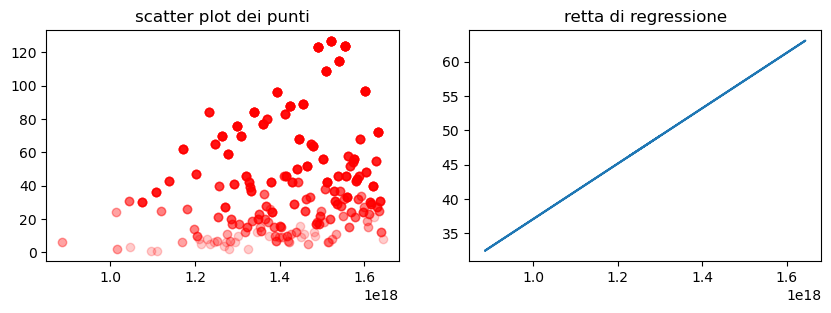

In [37]:
x = daTed[["date"]].values.astype(float)
y = daTed["count_date"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1)
regressor = LinearRegression()
lin_reg = regressor.fit(x_train, y_train)

print('Score:', lin_reg.score(x_valid, y_valid))

plt.figure(figsize=(10, 3)) 

plt.subplot(1, 2, 1)
y_hat = lin_reg.predict(x_valid)
plt.title("scatter plot dei punti")
plt.scatter(x_valid, y_valid,c='r',alpha=0.2) 

plt.subplot(1, 2, 2)
plt.title("retta di regressione")
plt.plot(x_valid,y_hat) 

plt.show()

In questo caso il modello ottenuto è più vicino ad un modello in cui i valori sono sparati a caso, quindi non è un modello molto preciso.

In [38]:
print ('MAE:',  MAE(list(y_valid), list(y_hat)))
print ('MSE: ', MSE(list(y_valid), list(y_hat)))
print ('RMSE:', RMSE(list(y_valid), list(y_hat)))

MAE: 27.004702442901003
MSE:  1029.5179280227997
RMSE: 32.08610178913605


### Proviamo a vedere se si riesce a creare un buon modello di regressione in cui dato un tag si riesce ad individuare il numero di view e like del video.

Score: 0.9984982800868291


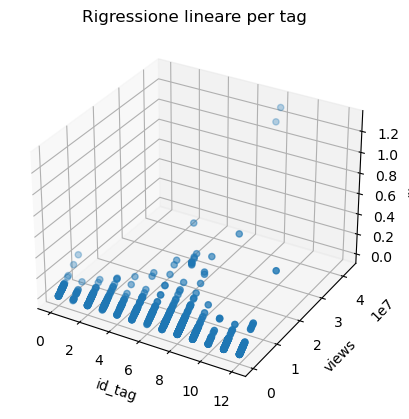

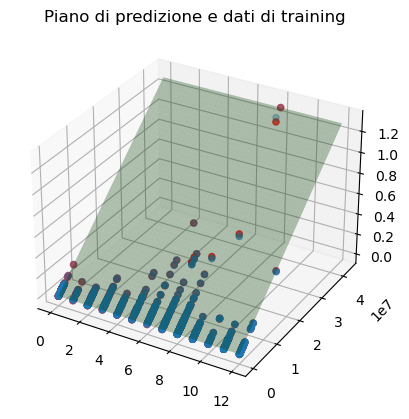

In [39]:
xy_train, xy_valid, z_train, z_valid = train_test_split(daTag[['id_tag', 'views']], daTag['likes'], test_size=0.2, random_state=1)
regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)

ax = plt.axes(projection ='3d')
ax.scatter(daTag["id_tag"], daTag["views"], daTag["likes"])
ax.set_xlabel("id_tag")
ax.set_ylabel("views")
ax.set_zlabel("likes")
ax.set_title('Rigressione lineare per tag')
z_pred_train = create_3d_plot(xy_train, z_train, "id_tag", "views", lin_reg, plt)


Il risultato ottenuto è buono, nonostante la matrice di correlazione creata precedentemente sulle stesse variabili non mostrasse una correllazione molto forte tra quest'ultime.

### Proviamo a predire data una data il numero di views e like di un video.

Score: 0.9992605601358914


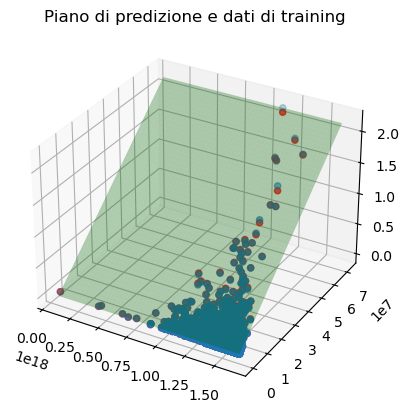

In [40]:
xy = pd.DataFrame({
                    'date': daTed['date'].values,
                    'views': daTed['views'].values
                  })

xy["date"] = xy["date"].astype(int)

z  = daTed["likes"]

xy_train, xy_valid, z_train, z_valid = train_test_split(xy, z, test_size=0.2, random_state=1)

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)

z_pred_train = create_3d_plot(xy_train, z_train, "date", "views", lin_reg, plt)

Il modello ottenuto si avvicina di moloto al modello perfetto (lo score risulta essere molto vicino ad 1).

Score: 0.9992605601358914


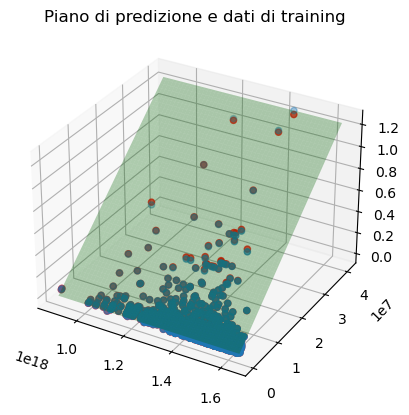

In [41]:
z_pred_valid = create_3d_plot(xy_valid, z_valid, "date", "views", lin_reg, plt)

In [42]:
print ('MAE:',  MAE(list(z_valid), list(z_pred_valid)))
print ('MSE: ', MSE(list(z_valid), list(z_pred_valid)))
print ('RMSE:', RMSE(list(z_valid), list(z_pred_valid)))

MAE: 1152.2871794660255
MSE:  8034853.998544548
RMSE: 2834.5818031139174


### Versione con il modello nullo

In [43]:
mean_likes = xy_valid['views'].mean()
null_model_y = [mean_likes] * xy_valid['views'].shape[0]

print ('MAE: ',  MAE(list(xy_valid['views']), list(null_model_y)))
print ('MSE: ', MSE(list(xy_valid['views']), list(null_model_y)))
print ('RMSE:', RMSE(list(xy_valid['views']),list(null_model_y)))

MAE:  1745883.0642689778
MSE:  11808525886038.49
RMSE: 3436353.5740721575


Da questi risultati possiamo vedere come tutte le seguenti misure: MAE (errore medio assoluto), MSE (errore quadratico medio) e RMSE (radice dell'errore quadratico medio) del modello nullo siano di gran nulli magggiori rispetto a quello in cui si tira a caso la media.<br>
Ciò significa che il nostro modello di predizione ottenuto è più efficace rispetto ad un modello in cui non esiste un metodo di predizione vero e proprio ma si tira solamente a caso prendendo solo in considerazione la media.

### TEST REGRESSION VIEWS, LIKES -> DATA

Dopo aver visto che il test di regressione fra like e views da un modello molto buono, che arriva quasi alla perfezione, abbiamo pensato di provare a predirre qualcosa di più complesso così da poter vedere se avremmo ottenuto gli stessi risultati.<br>
Così abbiamo provato a fare il test di regressione passando come dati in input i like e le view di un video cercando di predirne la data.

Score: 0.011730292928266772


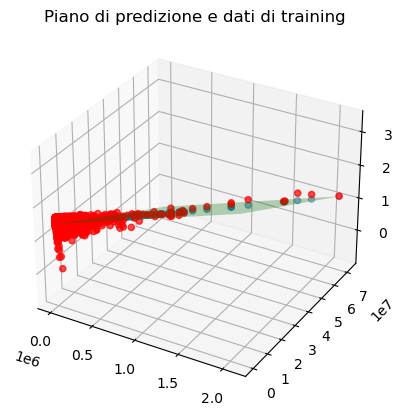

In [44]:
xy_train, xy_valid, z_train, z_valid = train_test_split(daTed[['likes', 'views']], daTed['date'], test_size=0.2, random_state=1)

z_train = z_train.values.astype(float)
z_valid = z_valid.values.astype(float)

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)

z_pred_train = create_3d_plot(xy_train, z_train, "likes", "views", lin_reg, plt)

Come possiamo vedere dal risultato di questo score il modello utilizzato non approssima tanto bene i dati che abbiamo nel dataframe.

# 5. Clustering

### Clustering date_int, views e likes

Abbiamo cercato di fare il clustering, così da vedere e o riceracare le corrispondenze, tra la data, le visualizzazione e i like dei vari video Ted prensenti nel nostro dataset.<br>

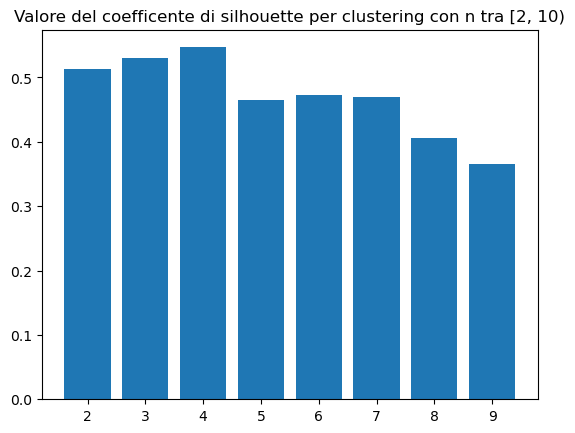

Il numero di cluster massimo individuato è:  4 
Stampa del grafico clusterizzato con 4 cluster


(0.5468978106887394,
 array([[0.92749606, 0.02002601, 0.02086015],
        [0.76784786, 0.02173431, 0.02257194],
        [0.80488485, 0.5138853 , 0.52791124],
        [0.84285049, 0.13875267, 0.14566173]]))

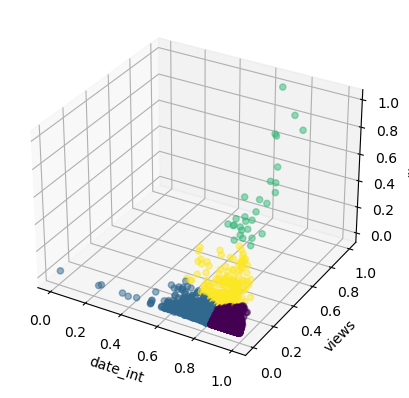

In [45]:
daTed['date_int'] = daTed['date'].astype(int)
sil_list = []
max_k = 0

for k in range(2, 10):
    r, _ = cluster_df(daTed, 'date_int', 'views', 'likes', k)
    sil_list.append (r)
    if(sil_list[max_k] < sil_list[len(sil_list)-1]):
        max_k = len(sil_list)-1

plt.title("Valore del coefficente di silhouette per clustering con n tra [2, 10)")
plt.bar([x for x in range(2,10)], sil_list)
plt.show()
        
print(
      "Il numero di cluster massimo individuato è: ", max_k+2, 
      "\nStampa del grafico clusterizzato con", max_k+2, "cluster"
     )


cluster_df(daTed, 'date_int', 'views', 'likes', max_k+2, make_plot=1)

Con i seguenti centroidi ottenuti, si potrebbe pensare di aver suddiviso il dataset in 4 parti dove: 
+ (viola) con il centroide con valori (data = 0.92749606, view = 0.02002601 e like = 0.02086015) come la parte dei ted più recenti ma con meno like e views
+ (blue) con il centroide con valori (data = 0.76784786, view = 0.02173431 e like =  0.02257194) come la parte dei ted più vecchia
+ (verde) con il centroide con valori (data = 0.80488485, view = 0.5138853  e like =  0.52791124) come la parte dei ted tra gli anni 2015-2020 con più like e più views
+ (gialla) con il centroide con valori (data = 0.84285049, view =  0.13875267 e like = 0.14566173) i ted talk con data compresa probabilmente tra gli anni 2015-2020 con i like e view più bassi

### Clustering date_year, mean_views_year e count_year

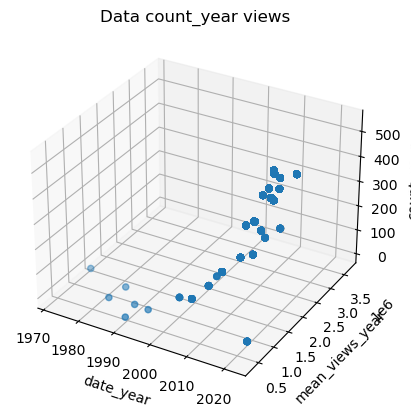

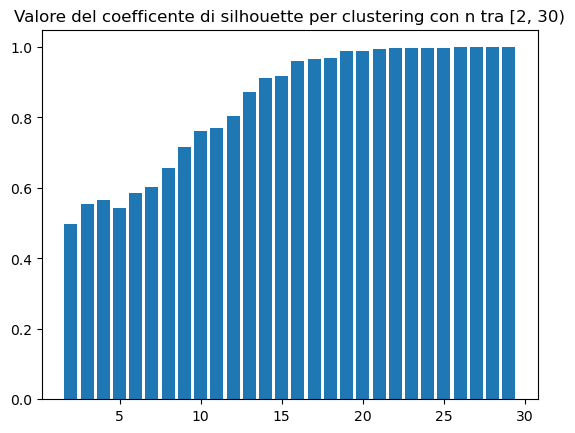

Il numero di cluster massimo individuato è:  26 
Stampa del grafico clusterizzato con 26 cluster


(0.9992668908305774,
 array([[8.60000000e-01, 8.12072350e-01, 6.92449355e-01],
        [9.40000000e-01, 4.20247821e-01, 1.00000000e+00],
        [7.60000000e-01, 4.90060821e-01, 4.89871087e-01],
        [9.80000000e-01, 2.29991186e-01, 7.16390424e-01],
        [6.20000000e-01, 3.77790821e-01, 6.07734807e-02],
        [8.40000000e-01, 5.88565852e-01, 6.55616943e-01],
        [6.80000000e-01, 1.00000000e+00, 8.83977901e-02],
        [9.00000000e-01, 5.01900084e-01, 9.09760589e-01],
        [8.00000000e-01, 6.92333491e-01, 5.54327808e-01],
        [7.40000000e-01, 6.13300141e-01, 4.27255985e-01],
        [9.60000000e-01, 2.78352479e-01, 9.24493554e-01],
        [6.60000000e-01, 6.22042829e-01, 1.17863720e-01],
        [1.00000000e+00, 7.31644531e-02, 3.49907919e-02],
        [9.20000000e-01, 4.12392505e-01, 8.69244936e-01],
        [7.00000000e-01, 3.66945165e-01, 2.06261510e-01],
        [8.20000000e-01, 7.15764640e-01, 7.12707182e-01],
        [8.80000000e-01, 5.93940240e-01, 7.32965009

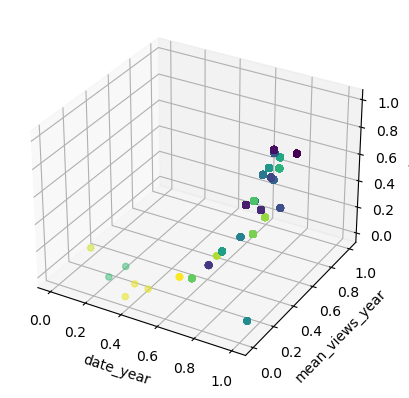

In [46]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(daTed["date_year"], daTed["mean_views_year"], daTed["count_year"])
ax.set_xlabel("date_year")
ax.set_ylabel("mean_views_year")
ax.set_zlabel("count_year")
ax.set_title('Data count_year views')
# create_3d_plot_gif(ax, fig)
plt.show()

sil_list = []
max_k = 0

for k in range(2, 30):
    r, _ = cluster_df(daTed, 'date_year', 'mean_views_year', 'count_year', k)
    sil_list.append (r)
    if(sil_list[max_k] < sil_list[len(sil_list)-1]):
        max_k = len(sil_list)-1

plt.title("Valore del coefficente di silhouette per clustering con n tra [2, 30)")
plt.bar([x for x in range(2,30)], sil_list)
plt.show()
        
print(
      "Il numero di cluster massimo individuato è: ", max_k+2, 
      "\nStampa del grafico clusterizzato con", max_k+2, "cluster"
     )


cluster_df(daTed, 'date_year', 'mean_views_year', 'count_year', max_k+2, make_plot=1)

### Clustering id_tag, views e likes

0.557882734647569


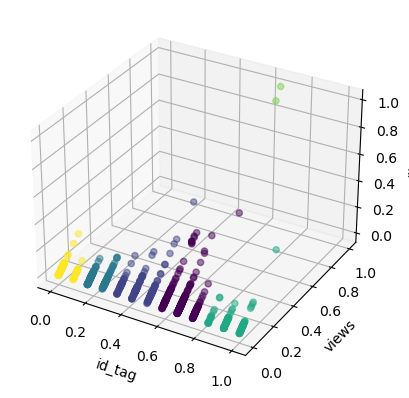

In [47]:
sil_list = []
max_k = 0
r, s = cluster_df(daTag, 'id_tag', 'views', 'likes', 6, make_plot=1)
print(r)